# Using Grover’s Algorithm for factorisation of bi-primes
## Submitted by Sukrit Jindal (sukjingitsit) [22125037, DSAI]

### Part I - Importing the required libraries
#### For this project I made use of Pennylane as my framework for Quantum Computing as it was easier to initialize and work with than Qiskit. Also, it supports the Tensorflow backend which can be accelerated by MPS shaders to use the GPU on my native system.

In [1]:
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
import math

### Part II - Initialisation
#### In this step, I have initialised the number and the Pennylane device used for calculations. There are three sets of wires used, p, q and z. Of these, p and q are used for the wires corresponding to the "probabilities" (quantum superposition) of the prime numbers and z is used for storing the results of their multiplication to apply the algorithm. I did initially try running on a quantum simulator backend like qasm_simulator and ibmq_tokyo, but was facing errors in a few operations.

In [2]:
# In Pennylane (QML), qubits are denoted as wires
N = 115
# Here the n_wires is 1 less than the actual numbers required to represent N to avoid 1 and N being considered in the solution
n_wires = math.ceil(math.log(N+1, 2)) - 1
dev = qml.device('default.qubit', wires = 4*n_wires) # qml.device('qiskit.ibmq', wires=4*n_wires, backend='ibmq_tokyo', ibmqx_token="XXX")
wires_p = [i for i in range(n_wires)]
wires_q = [i for i in range(n_wires, 2*n_wires)]
wires_z = [i for i in range(2*n_wires, 4*n_wires)]
print(f"p and q use {n_wires} wires while z uses {2*n_wires} wires for a total of {4*n_wires} wires")

p and q use 6 wires while z uses 12 wires for a total of 24 wires


### Part III - Arithmetic Operations
#### This part defines the functions for arithmetic on the wires using Fourier transforms in accordance with the paper Quantum Arithmetic with the Quantum Fourier Transform (Lidia Ruiz-Perez and Juan Carlos Garcia-Escartin). The implementation itself is based on Pennylane's provided tutorials.

In [3]:
# AddFourier indicates the phase shift for each wire as per the Fourier transform
def AddFourier(k, wires):
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])

# The multiply function implemented using QFT and AddFourier 
def Multiply(wires_p, wires_q, wires_z):
    # Prepare the wires of z, which store the products of the wires of p and q, for the quantum QFT operation
    qml.QFT(wires=wires_z)

    # Iteratively multiplying each bit and applying the resultant shift to the corresponding bit(s) of z
    for i in range(len(wires_p)):
        for j in range(len(wires_q)):
            coeff = 2 ** (len(wires_p) + len(wires_q) - i - j - 2)
            qml.ctrl(AddFourier, control=[wires_p[i], wires_q[j]])(coeff, wires_z)

    # return to computational basis
    qml.adjoint(qml.QFT)(wires=wires_z)

### Part IV - The Factorization Algorithm
#### This part defines the main function to be used for factorization. It is decorated with the qml.qnode(dev) function as an indicator that this function will operate on the device specified previously. The oracle used simply checks whether the product if the wires of p and q is N or not and is based on the simple Grover Factorization algorithm described in the paper Quantum Factoring Algorithm using Grover Search (S. Whitlock and T. D. Kieu) [before they define their own version which further optimizes the algorithm using the properties of bi-primes].

In [4]:
@qml.qnode(dev)
def GroverFactorization(N, wires_p, wires_q, wires_z, n_epochs):
    # Superposition of the input wires of p and q using a Hadamard gate (H-gate) to superimpose them in a uniform state
    for wire in wires_p + wires_q:
        qml.Hadamard(wires=wire)
    # Applying the oracle and Grover search
    for _ in range(n_epochs):
        # The oracle first has to calculate the product of the wire of p and q
        Multiply(wires_p, wires_q, wires_z)
        # The oracle flips the sign for the correct product for Grover search, which happens when the wires multiply to the value of N
        qml.FlipSign(N, wires=wires_z)
        # The oracle then uncomputes the multiplication, essentially reversing the multiplication process and resetting the bits of z
        qml.adjoint(Multiply)(wires_p, wires_q, wires_z)
        # Apply the Grover operator, which diffuses the amplitudes of the incorrect states to increase the probability of the correct states
        qml.GroverOperator(wires=wires_p + wires_q)
    # Measure the probabilities of the wires of p and q to obtain one of the factors of N, which will be equivalent due to symmetric operations
    return qml.probs(wires=wires_p), qml.probs(wires=wires_q)

### Part V - Running the Algorithm
#### The factorization algorithm is run for an O(√n) times. For bi-primes, this graph will almost certainly contain one or two maxima (one maxima when the bi-prime is the square of a prime, two otherwise), even for a single epoch, albeit using multiple epochs ensures its stability, convergence and correctness of the Grover search.

In [5]:
n_epochs = math.ceil(math.sqrt(N))
print(f"The grover search will run for {n_epochs} epochs")
resultp, resultq = GroverFactorization(N, wires_p, wires_q, wires_z, n_epochs)

The grover search will run for 11 epochs


#### The results vector contain the probabilities is plotted and the peaks are visualized (they are symmetric in p and q)

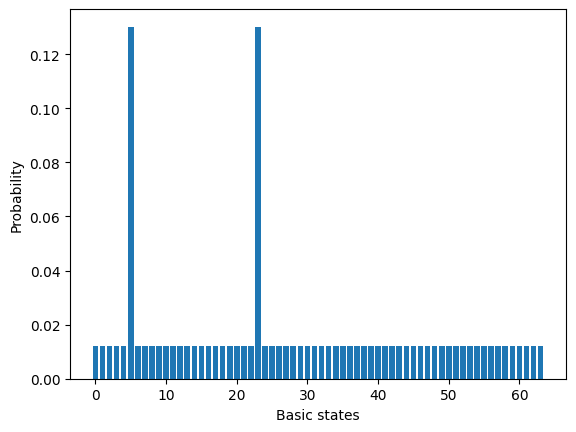

In [6]:
plt.bar(range(2 ** len(wires_p)), resultp)
plt.xlabel("Basic states")
plt.ylabel("Probability")
plt.show()

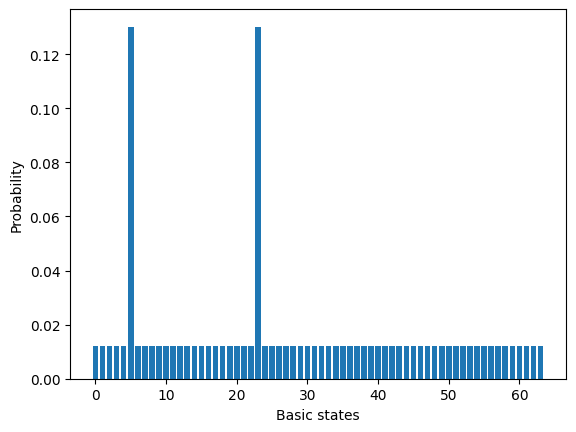

In [7]:
plt.bar(range(2 ** len(wires_q)), resultq)
plt.xlabel("Basic states")
plt.ylabel("Probability")
plt.show()

#### The two most probable states, corresponding to the prime factors of the bi-prime are extracted and printed as the answer. Rounding is done to extract the primes due to numerical issues where the probabilities of the two prime factors are similar but not precisely the same. The case of the bi-prime being the square of a prime is also considered

In [8]:
result = np.round(np.array(resultp), 6)
list_result = list(*np.where(result == np.max(result)))
p, q = list_result if len(list_result) == 2 else (list_result[0], list_result[0])

print(f"The prime factors of the bi-prime number {N} are {p} and {q}")

The prime factors of the bi-prime number 115 are 5 and 23


### Part VI - Visualising the Quantum Circuit
#### The Quantum Circuit used for the GroverFactorization algorithm is visualized and explained below

In [9]:
drawer = qml.draw(GroverFactorization)
print(drawer(N, wires_p, wires_q, wires_z, n_epochs))

 0: ──H───╭●───────────╭●───────────╭●──────────╭●──────────╭●──────────╭●──────────╭●────────
 1: ──H───│────────────│────────────│───────────│───────────│───────────│───────────│─────────
 2: ──H───│────────────│────────────│───────────│───────────│───────────│───────────│─────────
 3: ──H───│────────────│────────────│───────────│───────────│───────────│───────────│─────────
 4: ──H───│────────────│────────────│───────────│───────────│───────────│───────────│─────────
 5: ──H───│────────────│────────────│───────────│───────────│───────────│───────────│─────────
 6: ──H───├●───────────├●───────────├●──────────├●──────────├●──────────├●──────────├●────────
 7: ──H───│────────────│────────────│───────────│───────────│───────────│───────────│─────────
 8: ──H───│────────────│────────────│───────────│───────────│───────────│───────────│─────────
 9: ──H───│────────────│────────────│───────────│───────────│───────────│───────────│─────────
10: ──H───│────────────│────────────│───────────│─

##### As can be the wires of p (from 0 to n_wires-1) and q (from n_wires to 2 * n_wires-1) are initialised in a superposition state using a Hadamard gate. The wires of z (from 2 * n_wires to 4 * n_wires-1) store the product of the wires of p and q using a QFT operation which is applied iteratively n_epochs times till convergence. Within each epoch after the QFT operation to multiply the wires of p and q, the oracle flips the sign of the correct product of p and q and then uncomputes the multiplication to reset the wires of z for the next iteration. The Grover operator is then applied to increase the probability of the correct states and reduce the probability of the incorrect states. Finally, the probabilities of the wires of p are measured to obtain the factors of N. The wires of q are equivalent to the wires of p.